In [1]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib
import pyspark
import pyspark.pandas as ps

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
# engine = create_engine('postgresql+psycopg2://postgres:@localhost/bdtest')

In [4]:
words_df = pd.read_csv("OnlineNewsPopularity.csv", usecols=[' kw_avg_avg', ' is_weekend', \
' data_channel_is_entertainment', ' data_channel_is_tech', ' data_channel_is_socmed', ' self_reference_avg_sharess', ' LDA_02', ' self_reference_min_shares', \
' kw_max_max', ' n_tokens_content', ' min_positive_polarity', ' kw_min_max', ' num_keywords', ' title_sentiment_polarity', ' kw_max_min', ' shares'])

In [5]:
words_df.columns = words_df.columns.str.lstrip()

In [6]:
words_df.head()

,n_tokens_content,num_keywords,data_channel_is_entertainment,data_channel_is_socmed,data_channel_is_tech,kw_max_min,kw_min_max,kw_max_max,kw_avg_avg,self_reference_min_shares,self_reference_avg_sharess,is_weekend,LDA_02,min_positive_polarity,title_sentiment_polarity,shares
0,219.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.000000,0.0,0.040005,0.100000,-0.187500,593
1,255.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.050096,0.033333,0.000000,711
2,211.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.000000,0.0,0.033351,0.100000,0.000000,1500
3,531.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.494651,0.136364,0.000000,1200
4,1072.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,545.0,3151.157895,0.0,0.028575,0.033333,0.136364,505


In [7]:
words_df.loc[words_df["shares"] >= 1400, "Label"] = 1
words_df.loc[words_df["shares"] < 1400, "Label"] = 0

In [8]:
words = words_df.drop('shares', axis=1)

In [9]:
words.head()

,n_tokens_content,num_keywords,data_channel_is_entertainment,data_channel_is_socmed,data_channel_is_tech,kw_max_min,kw_min_max,kw_max_max,kw_avg_avg,self_reference_min_shares,self_reference_avg_sharess,is_weekend,LDA_02,min_positive_polarity,title_sentiment_polarity,Label
0,219.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.000000,0.0,0.040005,0.100000,-0.187500,0.0
1,255.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.050096,0.033333,0.000000,0.0
2,211.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.000000,0.0,0.033351,0.100000,0.000000,1.0
3,531.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.494651,0.136364,0.000000,0.0
4,1072.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,545.0,3151.157895,0.0,0.028575,0.033333,0.136364,0.0


In [10]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [11]:
spark = (SparkSession
.builder
.appName("SparkSQLExampleApp")
.getOrCreate())

In [ ]:
words_spark = ps.from_pandas(words)

In [ ]:
df_spark = words_spark.to_spark()

In [15]:
df_spark.show(5)

+----------------+------------+-----------------------------+----------------------+--------------------+----------+----------+----------+----------+-------------------------+--------------------------+----------+---------------+---------------------+------------------------+-----+
|n_tokens_content|num_keywords|data_channel_is_entertainment|data_channel_is_socmed|data_channel_is_tech|kw_max_min|kw_min_max|kw_max_max|kw_avg_avg|self_reference_min_shares|self_reference_avg_sharess|is_weekend|         LDA_02|min_positive_polarity|title_sentiment_polarity|Label|
+----------------+------------+-----------------------------+----------------------+--------------------+----------+----------+----------+----------+-------------------------+--------------------------+----------+---------------+---------------------+------------------------+-----+
|           219.0|         5.0|                          1.0|                   0.0|                 0.0|       0.0|       0.0|       0.0|       0.0|  

In [16]:
df_spark.printSchema()

root
 |-- n_tokens_content: double (nullable = false)
 |-- num_keywords: double (nullable = false)
 |-- data_channel_is_entertainment: double (nullable = false)
 |-- data_channel_is_socmed: double (nullable = false)
 |-- data_channel_is_tech: double (nullable = false)
 |-- kw_max_min: double (nullable = false)
 |-- kw_min_max: double (nullable = false)
 |-- kw_max_max: double (nullable = false)
 |-- kw_avg_avg: double (nullable = false)
 |-- self_reference_min_shares: double (nullable = false)
 |-- self_reference_avg_sharess: double (nullable = false)
 |-- is_weekend: double (nullable = false)
 |-- LDA_02: double (nullable = false)
 |-- min_positive_polarity: double (nullable = false)
 |-- title_sentiment_polarity: double (nullable = false)
 |-- Label: double (nullable = false)



In [18]:
trainDF, testDF = df_spark.randomSplit([.7,.3], seed=42)
print(f"""{trainDF.count()} записей в тренировочном датасете и {testDF.count()} записей в тестовом датасете""")

27924 записей в тренировочном датасете и 11720 записей в тестовом датасете


In [19]:
trainDF.dtypes

[('n_tokens_content', 'double'),
 ('num_keywords', 'double'),
 ('data_channel_is_entertainment', 'double'),
 ('data_channel_is_socmed', 'double'),
 ('data_channel_is_tech', 'double'),
 ('kw_max_min', 'double'),
 ('kw_min_max', 'double'),
 ('kw_max_max', 'double'),
 ('kw_avg_avg', 'double'),
 ('self_reference_min_shares', 'double'),
 ('self_reference_avg_sharess', 'double'),
 ('is_weekend', 'double'),
 ('LDA_02', 'double'),
 ('min_positive_polarity', 'double'),
 ('title_sentiment_polarity', 'double'),
 ('Label', 'double')]

In [20]:
assemblerInputs = [field for (field, dataType) in trainDF.dtypes if ((dataType == "double") & (field != "Label"))]
vecAssembler = VectorAssembler(inputCols=assemblerInputs,
                               outputCol="features") 

In [21]:
dt = DecisionTreeClassifier(labelCol="Label", featuresCol="features", seed=42)

stages = [vecAssembler, dt]

pipeline = Pipeline(stages=stages)
dt.setMaxBins(40)
pipelineModel = pipeline.fit(trainDF)

In [23]:
predDF = pipelineModel.transform(testDF)
predDF.select("features", "Label", "prediction").show(30)

+--------------------+-----+----------+
|            features|Label|prediction|
+--------------------+-----+----------+
|(15,[1,5,6,7,8,12...|  1.0|       0.0|
|(15,[1,5,7,8,11,1...|  1.0|       1.0|
|(15,[1,5,7,8,12,1...|  1.0|       0.0|
|(15,[1,5,7,8,12,1...|  1.0|       1.0|
|(15,[1,4,5,7,8,12...|  1.0|       1.0|
|(15,[1,4,5,7,8,12...|  1.0|       1.0|
|(15,[1,3,5,7,8,11...|  1.0|       1.0|
|[0.0,9.0,1.0,0.0,...|  1.0|       0.0|
|(15,[1,5,7,8,12,1...|  0.0|       1.0|
|(15,[1,5,7,8,12,1...|  0.0|       0.0|
|(15,[1,5,7,8,12],...|  0.0|       1.0|
|(15,[1,3,5,6,7,8,...|  1.0|       1.0|
|(15,[1,2,5,6,7,8,...|  1.0|       0.0|
|(15,[1,2,5,6,7,8,...|  0.0|       0.0|
|(15,[1,2,5,6,7,8,...|  0.0|       0.0|
|(15,[0,1,5,7,8,12...|  1.0|       1.0|
|[21.0,8.0,0.0,0.0...|  1.0|       1.0|
|[27.0,6.0,0.0,0.0...|  0.0|       1.0|
|(15,[0,1,5,7,8,11...|  1.0|       1.0|
|[32.0,10.0,0.0,0....|  0.0|       0.0|
|(15,[0,1,5,7,8,12...|  0.0|       0.0|
|[37.0,10.0,0.0,0....|  0.0|       0.0|


In [25]:
dtModel = pipelineModel.stages[-1]

In [26]:
featureImp = pd.DataFrame(list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)), columns=["feature", "importance"])
featureImp.sort_values(by="importance", ascending=False)

,feature,importance
8,kw_avg_avg,0.350485
2,data_channel_is_entertainment,0.144778
11,is_weekend,0.144438
4,data_channel_is_tech,0.102748
3,data_channel_is_socmed,0.083331
10,self_reference_avg_sharess,0.072001
12,LDA_02,0.040639
6,kw_min_max,0.016475
7,kw_max_max,0.012741
0,n_tokens_content,0.011978


In [28]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDF)
print("Ошибка = %g " % (1.0 - accuracy))

Ошибка = 0.358362 


In [ ]:
with mlflow.start_run(run_name="decision-tree") as run:
    # Log model
    pipelineModel = pipeline.fit(trainDF)
    mlflow.spark.log_model(pipelineModel, "Model")
    
    predDF = pipelineModel.transform(testDF)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction")
    accuracy = evaluator.setMetricName('accuracy').evaluate(predDF)
    weightedPrecision = evaluator.setMetricName('weightedPrecision').evaluate(predDF)
    mlflow.log_metrics({"accuracy": accuracy, "weightedPrecision": weightedPrecision})
    dtModel = pipelineModel.stages[-1]
    featureImp = (pd.DataFrame(list(zip(vecAssembler.getInputCols(), 
                                        dtModel.featureImportances)), 
                                        columns=["feature", "importance"])
                  .sort_values(by="importance", ascending=False))
    featureImp.to_csv("feature-importance.csv", index=False)
    mlflow.log_artifact("feature-importance.csv")

In [29]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
df = spark.createDataFrame(
    data=[
        (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
        (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),),
        (Vectors.dense([8.0, 1.0, 4.0, 9.0, 0.0]),),
    ],
    schema=["features"]
)
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df)

In [30]:
result.show(truncate=False)

+---------------------+----------------------------------------+
|features             |pcaFeatures                             |
+---------------------+----------------------------------------+
|[2.0,0.0,3.0,4.0,5.0]|[-0.3579454550086063,2.8552717568779067]|
|[4.0,0.0,0.0,6.0,7.0]|[-0.15702924479502833,7.433440897099073]|
|[8.0,1.0,4.0,9.0,0.0]|[-9.435959482592683,5.219518215051579]  |
+---------------------+----------------------------------------+



In [31]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
Y = iris.target # вид ириса, всего их 3 и пронумерованы (0, 1 или 2)

In [32]:
attributes = [
    'Sepal Length',
    'Sepal Width',
    'Petal Length',
    'Petal Width'
]
data = spark.createDataFrame(
    data=X.tolist(),
    schema=attributes)

In [33]:
data.show(5)

+------------+-----------+------------+-----------+
|Sepal Length|Sepal Width|Petal Length|Petal Width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



In [34]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=attributes,
    outputCol="features"
)
output = assembler.transform(data)

In [35]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(output)
result = model.transform(output)# .select("pcaFeatures")

In [36]:
result.show(5, truncate=False)

+------------+-----------+------------+-----------+-----------------+----------------------------------------+
|Sepal Length|Sepal Width|Petal Length|Petal Width|features         |pcaFeatures                             |
+------------+-----------+------------+-----------+-----------------+----------------------------------------+
|5.1         |3.5        |1.4         |0.2        |[5.1,3.5,1.4,0.2]|[-2.8182395066394674,-5.646349823412792]|
|4.9         |3.0        |1.4         |0.2        |[4.9,3.0,1.4,0.2]|[-2.788223445314679,-5.149951351762912] |
|4.7         |3.2        |1.3         |0.2        |[4.7,3.2,1.3,0.2]|[-2.6133745635497077,-5.182003150742134]|
|4.6         |3.1        |1.5         |0.2        |[4.6,3.1,1.5,0.2]|[-2.7570222769675947,-5.008653597575776]|
|5.0         |3.6        |1.4         |0.2        |[5.0,3.6,1.4,0.2]|[-2.773648596054474,-5.653707089762611] |
+------------+-----------+------------+-----------+-----------------+----------------------------------------+
o

In [37]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol="pcaFeatures", outputCol="attr_1", indices=[0])
sliced = slicer.transform(result)
slicer = VectorSlicer(inputCol="pcaFeatures", outputCol="attr_2", indices=[1])
sliced = slicer.transform(sliced)

In [38]:
sliced.select('attr_1', 'attr_2').show(5)

+--------------------+--------------------+
|              attr_1|              attr_2|
+--------------------+--------------------+
|[-2.8182395066394...|[-5.646349823412792]|
|[-2.788223445314679]|[-5.149951351762912]|
|[-2.6133745635497...|[-5.182003150742134]|
|[-2.7570222769675...|[-5.008653597575776]|
|[-2.773648596054474]|[-5.653707089762611]|
+--------------------+--------------------+
only showing top 5 rows



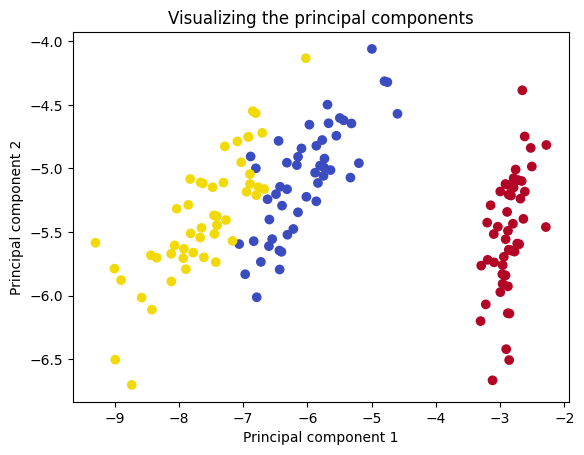

In [39]:
import matplotlib.pyplot as plt
x = sliced.select('attr_1').collect()
y = sliced.select('attr_2').collect()
colors_map = {
  0: '#b40426',
  1: '#3b4cc0',
  2: '#f2da0a',
}
# из кода выше Y = iris.target
colors = list(map(lambda p: colors_map[p], Y))
plt.scatter(x, y, c=colors)
plt.title(f'Visualizing the principal components')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()